# **Lab 7a - Explainable and Trustworthy AI**


---



**Teacher**: Eliana Pastor (eliana.pastor@polito.it)


---

## **Evaluating explanations - Tabular data**

We evaluate the explanation of individual predictions provided by SHAP.
We focus on the [Adult dataset](https://archive.ics.uci.edu/dataset/2/adult) and a Random Forest classifier, as done for Lab 3b.


> **Dataset.** The Adult dataset, also known as the "Census Income" dataset, contains demographic information about people, such as age, education, occupation, marital status and more, extracted from the 1994 U.S. Census Bureau database. **Each entry** in the dataset represents a **person**, and the associated **task** is to **predict whether an individual earns more than $50,000 per year** or less.

> **Model**

1. We first load the Adult dataset.
  * We use the dataset available in the SHAP [library](https://shap.readthedocs.io/en/latest/generated/shap.datasets.adult.html).
  * SHAP provides two versions of Adult dataset: an already preprocessed, that we will use for both the classifier and the explainer; the original dataset version, to interpret the results.
2. We split the Adult dataset. 80/20 train-test ratio.
3. We then rain a RandomForestClassifier and fit it over the training dataset. Evaluate the model.


> **Explanations**

4. Use the `shap.Explainer` to explain the instance `id=0` .
5. **Plot** with a bar chart from `matplotlib.pyplot` the **Shapley values** for the instance `id=0` .

In the following, we load the dataset, train the model and generate explanations with SHAP, as done for Lab 3b

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap

import random
random.seed(42)

/Users/eliana/miniconda3/envs/xailab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Data loading and splitting

We use the dataset already processed available in the shap library (see Lab 3b)

In [2]:
# Load the data with display=False. This dataset has been processed (label encoding)
X, y = shap.datasets.adult(display=False)

display(X.head(3))

# Load the data with display=True. This dataset still contains the categorical values.
X_display, y_display = shap.datasets.adult(display=True)
display(X_display.head(3))

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States


In [3]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_display_test, y_display_test = X_display.loc[X_test.index], y_display[X_test.index]

#### Model training

In [4]:
# Train a RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train.values, y_train)

RandomForestClassifier(random_state=42)

In [5]:
# Evaluate the model
accuracy = rf_clf.score(X_test.values, y_test)
accuracy

0.8565945033010901

#### SHAP - Explanation

In [6]:
# Consider an instance
id_instance = 0

instance_i, label_i = X_test.iloc[[id_instance]], y_test[0]
instance_i_display = X_display_test.iloc[[id_instance]]

predicted_class_i = rf_clf.predict(instance_i.values)[0]
display(instance_i)
print(f'True label: {label_i}')
print(f'Predicted label: {predicted_class_i}')

# Index of the predicted class
predicted_index = np.argmax(rf_clf.predict_proba(instance_i.values)[0])

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
26048,30.0,4,10.0,4,8,3,4,0,0.0,0.0,40.0,39


True label: False
Predicted label: False


In [7]:
# Compute the masker
masker = shap.maskers.Independent(data = X_train.values)

# Instanciate the shap.Explainer
explainer = shap.Explainer(rf_clf.predict_proba, masker=masker)

# Calculate the explainer over the sample_data
shap_values_explanation = explainer(instance_i)

# Estimated shapley values for the predicted class
shap_values_i = shap_values_explanation.values[:, :, predicted_index][0]

Text(0.5, 1.0, 'Shapley values for instance 0 \n w.r.t 0. Predicted class: False')

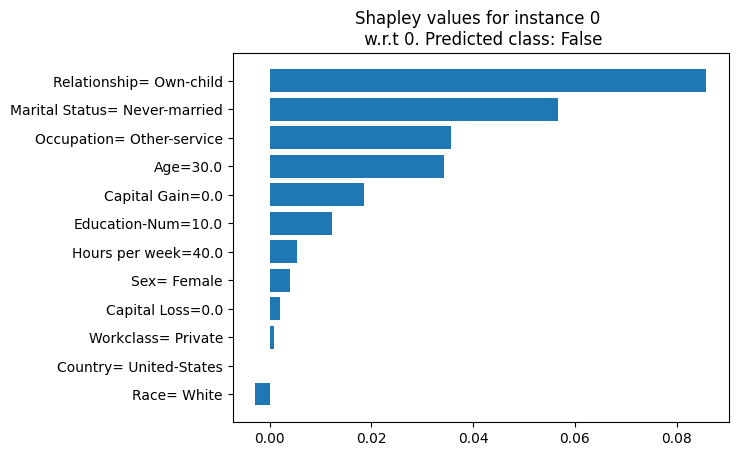

In [8]:
# Plot the shapley values

sorted_indices = np.argsort(shap_values_i)
feature_names_values = np.array([f'{f}={value}' for f, value in zip(instance_i_display.columns, instance_i_display.values[0])])

# Plot SHAP values
plt.barh(feature_names_values[sorted_indices], shap_values_i[sorted_indices])

# Plot title
plt.title(f'Shapley values for instance {id_instance} \n w.r.t {predicted_index}. Predicted class: {predicted_class_i}')


# **Exercises:**

## Single deletion

---


Single Deletion

>> Evaluates the change in output when removing/perturbing one feature

* Omitting the feature with the highest importance score for the explanation
should lead the highest change in the output of $f$
* Omitting the one with least importance should have no impact
* Omitting a feature that as no effect on the output should have importance 0

**Exercixe A - Study the impact of removing the most important feature**

1. Identify the most important feature for the prediction
Given the SHAP feature attribution score for the prediction of the instance $0$, identify the most important one (highest score)

2. Apply the single deletion of the most important feature

* Remove the most important feature
* Compute the prediction change of the perturbed instance with the original prediction probability
* Analyze the drop in the prediction change

#### 1. Which is the most important feature?

In [9]:
idx_max = np.argmax(shap_values_i)


most_important_attribute = instance_i_display.columns[idx_max]
most_important_encoded_value = instance_i.values[0][idx_max]
most_important_attribute_value = feature_names_values[idx_max]

print(f'Most important feature: {most_important_attribute_value}; encoded: {most_important_attribute} = {most_important_encoded_value}')

Most important feature: Relationship= Own-child; encoded: Relationship = 3.0


#### 2. Remove just the most important feature.

Compute the change in the prediction when we remove the most important feature

>> How to mimic the removal. Examples:


** Option (i)  we can remove it by replacing the value of the most important attribute with a random one.

** Option (ii) we replace the value of the most important feature iteratively with all the other possible values, we measure how the prediction changes and compute the average change in the prediction.

** Option (ii) we replace the values of the most importan feature $M$ times with the attribute value of randomly sampled instances.

In [10]:
# In this example, we will perturb the most important feature by changing its value to all possible values and calculate the difference in prediction.

prediction_orig = rf_clf.predict_proba(instance_i.values)[0][predicted_index]

single_removal = 0

for value, freq in dict(X_train[most_important_attribute].value_counts()).items():
        instance_perturbed = instance_i.copy()
        instance_perturbed[most_important_attribute] = value
        prob_pert = rf_clf.predict_proba(instance_perturbed.values)[0][predicted_index]
        # Difference in prediction
        diff = prediction_orig - prob_pert
        print(f'Value: {value};  Prediction: {prob_pert}; Difference: {diff:.4f}')
        # Accumulate the difference
        single_removal += diff

single_removal/=len(X_train[most_important_attribute].unique())

print(f'Average difference in prediction when removing the most important feature: {single_removal:.4f}')

Value: 4;  Prediction: 0.8792785547785548; Difference: 0.1207
Value: 0;  Prediction: 0.99; Difference: 0.0100
Value: 3;  Prediction: 1.0; Difference: 0.0000
Value: 1;  Prediction: 1.0; Difference: 0.0000
Value: 5;  Prediction: 0.9505; Difference: 0.0495
Value: 2;  Prediction: 1.0; Difference: 0.0000
Average difference in prediction when removing the most important feature: 0.0300


Does this alone explain the prediction?

## Iterative deletion of the most important feature

---


>> Evaluates the change in output when iteratively removing/perturbing features

* We can omit in descending order (from the most important to the least) or ascending order
* Often we removed subsets, e.g., top-k most influential and least
* The impact is then summarized, e.g., Area over the Perturbation Curve, average difference in prediction scores by f

**Exercixe B - Study the impact of removing the top-K important feature**

1. Identify the top-K most important feature for the prediction
Given the SHAP feature attribution score for the prediction of the instance $0$, identify the top K important ones (highest scores)

2. Apply the iterative deletion of the K important features

* Remove iteratively the K most important features, from the most important to the top-K and compute the prediction change
* Compute the average prediction change

Note that we are measuring if the top-K feature are comprehensive. If they are comprehensive, they capture most of the information and hence we expect a high drop in prediction probability. We define this measure as **comprehensiveness**

3. Apply the iterative deletion for random features

* Reapply the process but for random K features. We investigate whether the drop is change is indeed larger for the features highlighted by SHAP

4. Compare the score for the delition of the top-K features for SHAP and random removal




#### 1. Which are the K=5 most important features?

In [11]:
# argsort in descending order
sorted_indices = np.argsort(shap_values_i)[::-1]

top_K = 5

print('Most important features:',  list(X_train.columns[sorted_indices[:top_K]]))
print('Most important attibute values:', feature_names_values[sorted_indices[:top_K]])

Most important features: ['Relationship', 'Marital Status', 'Occupation', 'Age', 'Capital Gain']
Most important attibute values: ['Relationship= Own-child' 'Marital Status= Never-married'
 'Occupation= Other-service' 'Age=30.0' 'Capital Gain=0.0']


#### 2. Compute the iterative removal of the top-K most important features

In this case, we mimic the removal of a set of feature by replacing the values of the most important features $M$ times with the attribute value of randomly sampled instances.

We set $M$ = 50

In [12]:
import random

n_random_iterations = 50

# We will iteratively remove the top k features

iterative_removal = np.zeros(top_K)

for k in range(top_K):
    top_idxs = sorted_indices[:k+1]

    for m in range(n_random_iterations):

        # Copy the instance
        instance_perturbed = instance_i.values[0].copy() 

        # Randomly select an index
        random_idx = random.randint(0, X_train.shape[0])
        
        # Replace the value of the most important feature with the value of the random instance
        instance_perturbed[top_idxs] = X_train.iloc[random_idx].values[top_idxs]
        
        # Predict the perturbed instance
        prob_pert = rf_clf.predict_proba(instance_perturbed.reshape(1, -1))[0][predicted_index]
        
        # Difference in prediction
        diff = prediction_orig - prob_pert
        
        # Accumulate the difference
        iterative_removal[k] += diff

    iterative_removal[k] /= n_random_iterations

print('Iterative removal:', iterative_removal)

comprehensiveness = sum(iterative_removal)/top_K

print(comprehensiveness)

Iterative removal: [0.06252629 0.09610329 0.10679371 0.20563079 0.22907463]
0.14002574503274504


#### 3. Repeat the process but using a random explanation

Compute the iterative removal for K random features

In [13]:
import random

random.seed(42)

random_indexes = np.random.choice(X_train.shape[1], X_train.shape[1], replace=False)

n_random_iterations = 50

# We will iteratively remove the top k features

random_iterative_removal = np.zeros(top_K)

for k in range(top_K):
    top_idxs = random_indexes[:k+1]

    for m in range(n_random_iterations):

        # Copy the instance
        instance_perturbed = instance_i.values[0].copy() 

        # Randomly select an index
        random_idx = random.randint(0, X_train.shape[0])
        
        # Replace the value of the most important feature with the value of the random instance
        instance_perturbed[top_idxs] = X_train.iloc[random_idx].values[top_idxs]
        
        # Predict the perturbed instance
        prob_pert = rf_clf.predict_proba(instance_perturbed.reshape(1, -1))[0][predicted_index]
        
        # Difference in prediction
        diff = prediction_orig - prob_pert
        
        # Accumulate the difference
        random_iterative_removal[k] += diff

    random_iterative_removal[k] /= n_random_iterations

print('Random iterative removal:', random_iterative_removal)

random_comprehensiveness = sum(random_iterative_removal)/top_K

print(random_comprehensiveness)

Random iterative removal: [0.0052     0.0112     0.0054     0.06913714 0.08232857]
0.03465314285714287


#### 4. Compare the deletion of the most important feature with the random deletion of features

In [14]:
comprehensiveness, random_comprehensiveness

(0.14002574503274504, 0.03465314285714287)

## Correlation with Leave-One-Out

**Exercixe C - Analyze the correlation with Leave-One-Out**


Compute the Leave-One-Out (LOO) importance and compare it with the SHAP values using the rank correlation.

LOO importance is a basic explainer computed by removing one feature at a time and computing the difference in prediction. 

A measure of faithfulness is the correlation with LOO explanations.

####  1. Compute the Leave-One-Out (LOO) importance

The LOO importance is computed by removing one feature at a time and computing the difference in prediction. 

In [15]:
leave_one_out_importance = {}

for attr_ix, attribute_name in enumerate(X_train.columns):
    single_removal = 0
    prediction_orig = rf_clf.predict_proba(instance_i.values)[0][predicted_index]
    for value, freq in dict(X_train[attribute_name].value_counts()).items():
        instance_perturbed = instance_i.copy()
        instance_perturbed[attribute_name] = value
        prob_pert = rf_clf.predict_proba(instance_perturbed.values)[0][predicted_index]
        diff = prediction_orig - prob_pert
        single_removal += diff*freq/len(X_train)

    single_removal /= len(X_train[attribute_name].unique())
    leave_one_out_importance[feature_names_values[attr_ix]] = single_removal

#### 2. Plot the leave-one-out importance

<BarContainer object of 12 artists>

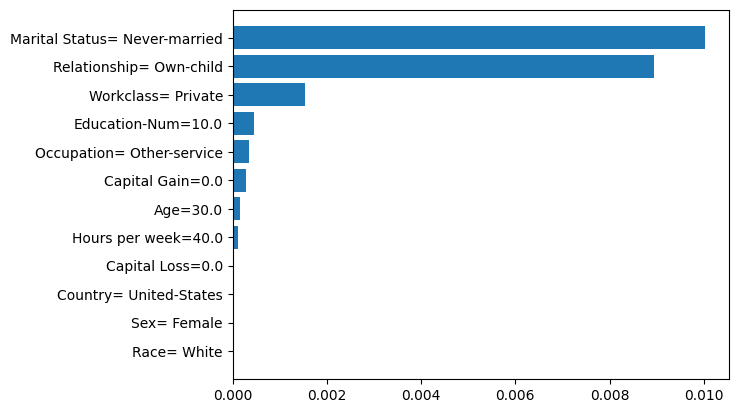

In [16]:
# Sort dictionary by values
leave_one_out_importance = dict(sorted(leave_one_out_importance.items(), key=lambda item: item[1]))

# Plot LOO values
plt.barh(list(leave_one_out_importance.keys()), list(leave_one_out_importance.values()))


#### 3. Visually compare the importance from the SHAP scores with the leave-one-out importance

Plot the two explanations provided by SHAP and LOO

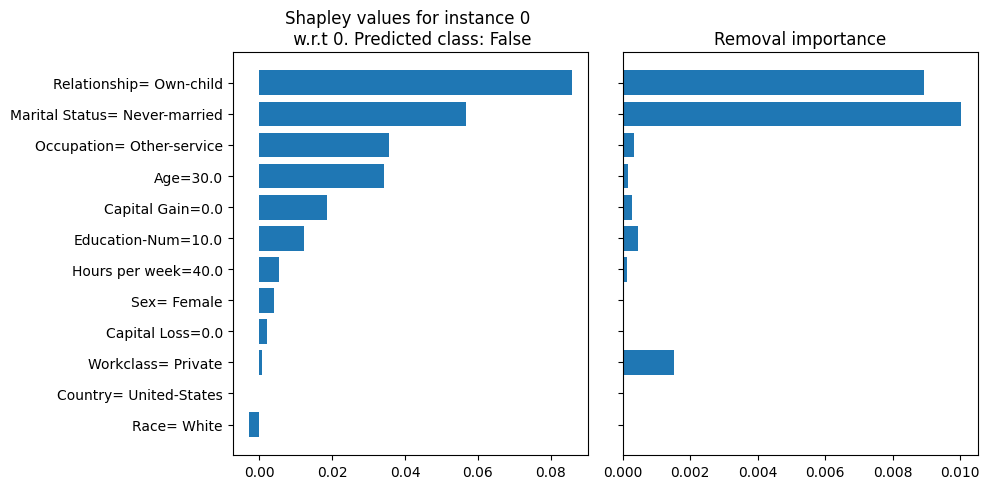

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sorted_indices = np.argsort(shap_values_i)

# Plot SHAP values
shap_values_dict = {k:v  for  k, v in zip(feature_names_values[sorted_indices], shap_values_i[sorted_indices])}

axs[0].barh(list(shap_values_dict.keys() ),list(shap_values_dict.values()))
axs[0].set_title(f'Shapley values for instance {id_instance} \n w.r.t {predicted_index}. Predicted class: {predicted_class_i}')

# Sort the removal importance via the values of the SHAP values
leave_one_out_importance_dict = {k: leave_one_out_importance[k] for k in shap_values_dict.keys()}
axs[1].barh(list(leave_one_out_importance_dict.keys()), list(leave_one_out_importance_dict.values()))
axs[1].set_title('Removal importance')
# Remove the xtiks from the second plot
axs[1].set_yticklabels([])
plt.tight_layout()
plt.show()

#### 4. Compute the rank correlation between the SHAP values and the leave-one-out importance

Compare the two explanation by computing a rank similarity score. For eaxample, use the spearmanr

In [18]:
from scipy import stats
res = stats.spearmanr(list(shap_values_dict.values()), list(leave_one_out_importance_dict.values()))
res

SignificanceResult(statistic=0.7075317330217298, pvalue=0.010054355455185422)

## Iterative deletion of the least important feature


---


>> Evaluates the change in output when iteratively removing/perturbing features the least important. We expect a null or small average change i the prediction probability

**Exercixe D - Study the impact of removing the least-K important feature**

1. Identify the least-K most important feature for the prediction
Given the SHAP feature attribution score for the prediction of the instance $0$, identify the least K important ones (lowest score)

2. Apply the iterative deletion of the K important features

* Remove iteratively the K most important features, from the most important to the top-K and compute the prediction change
* Compute the average prediction change

Note that we are measuring if the top-K feature are sufficient. If they are suffient, they capture **alone** most of the information and hence we expect a null or small drop in prediction probability. We define this measure as **sufficiency**

3. Apply the iterative deletion for random features

* Reapply the process but for random K features. 

4. Compare the score for the delition of the least-K features for SHAP and random removal


#### 1. Which are the K=5 least important features?

In [19]:
# argsort in descending order
sorted_indices_least = np.argsort(shap_values_i)

top_K = 5

print('Least important features:',  list(X_train.columns[sorted_indices_least[:top_K]]))
print('Least important attibute values:', feature_names_values[sorted_indices_least[:top_K]])

Least important features: ['Race', 'Country', 'Workclass', 'Capital Loss', 'Sex']
Least important attibute values: ['Race= White' 'Country= United-States' 'Workclass= Private'
 'Capital Loss=0.0' 'Sex= Female']


#### 2. Compute the iterative removal of the K least important features

In [20]:
import random

n_random_iterations = 50

prediction_orig = rf_clf.predict_proba(instance_i.values)[0][predicted_index]

# We will iteratively remove the top k features

iterative_removal = np.zeros(top_K)

for k in range(top_K):
    top_idxs = sorted_indices_least[:k+1]

    for m in range(n_random_iterations):

        # Copy the instance
        instance_perturbed = instance_i.values[0].copy() 

        # Randomly select an index
        random_idx = random.randint(0, X_train.shape[0])
        
        # Replace the value of the most important feature with the value of the random instance
        instance_perturbed[top_idxs] = X_train.iloc[random_idx].values[top_idxs]
        
        # Predict the perturbed instance
        prob_pert = rf_clf.predict_proba(instance_perturbed.reshape(1, -1))[0][predicted_index]
        
        # Difference in prediction
        diff = prediction_orig - prob_pert
        
        # Accumulate the difference
        iterative_removal[k] += diff

    iterative_removal[k] /= n_random_iterations

print('Iterative removal:', iterative_removal)

sufficiency = sum(iterative_removal)/top_K

print(sufficiency)

Iterative removal: [0.     0.0006 0.0062 0.0114 0.0144]
0.006520000000000001


#### 3. Repeat the process but using a random explanation

In [21]:
import random

random.seed(42)

random_indexes = np.random.choice(X_train.shape[1], X_train.shape[1], replace=False)

n_random_iterations = 50

# We will iteratively remove the top k features

random_iterative_removal = np.zeros(top_K)

for k in range(top_K):
    top_idxs = random_indexes[:k+1]

    for m in range(n_random_iterations):

        # Copy the instance
        instance_perturbed = instance_i.values[0].copy() 

        # Randomly select an index
        random_idx = random.randint(0, X_train.shape[0])
        
        # Replace the value of the most important feature with the value of the random instance
        instance_perturbed[top_idxs] = X_train.iloc[random_idx].values[top_idxs]
        
        # Predict the perturbed instance
        prob_pert = rf_clf.predict_proba(instance_perturbed.reshape(1, -1))[0][predicted_index]
        
        # Difference in prediction
        diff = prediction_orig - prob_pert
        
        # Accumulate the difference
        random_iterative_removal[k] += diff

    random_iterative_removal[k] /= n_random_iterations

print('Random iterative removal:', random_iterative_removal)

random_sufficiency = sum(random_iterative_removal)/top_K

print(random_sufficiency)

Random iterative removal: [0.003      0.11702857 0.151302   0.18556076 0.17398538]
0.126175343989344


#### 4. Compare the deletion of the most important feature with the random deletion of features

In [22]:
sufficiency, random_sufficiency

(0.006520000000000001, 0.126175343989344)